# Vehicle Price Prediction Project
Auteur : Data Scientist / ML Engineer
Date : Février 2026
Dataset : vente_vehicule_2026.csv (ventes automobiles françaises)

## Objectif
Développer un modèle de régression capable de prédire le prix de vente des véhicules d'occasion (€) à partir de caractéristiques comme l'âge, le kilométrage, la marque/modèle, et le type de carburant. Le modèle est destiné à une API de production (FastAPI) pour des prédictions en temps réel.

In [28]:
# Importing Libraries
import pandas as pd
import numpy as np
import sklearn as sk
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from modules.plot_pca import plot_pca_biplot_adaptive

from prince import MCA

import warnings

warnings.filterwarnings("ignore")

In [2]:
plt.style.use("dark_background")

mpl.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.grid": True,
    "grid.color": "#555555",
    "axes.facecolor": "#000000",
    "axes.edgecolor": "#cccccc",
    "text.color": "#ffffff",
    "axes.labelcolor": "#ffffff",
    "xtick.color": "#ffffff",
    "ytick.color": "#ffffff",
})
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["patch.edgecolor"] = "white"
plt.rcParams["patch.linewidth"] = 1.0

In [54]:
# Load Data
df = pd.read_csv('vente_vehicule_2026.csv')

## Chargement et exploration des données
Nous chargeons le fichier vente_vehicule_2026.csv dans un DataFrame pandas et réalisons une première exploration des données via head(), info() et describe().

Cette étape permet d’identifier la structure du jeu de données, les types de variables, les valeurs manquantes et les ordres de grandeur des principales métriques (prix, kilométrage, années).

In [5]:
# Data Exploration
df.head()

,date_facture,montant_total,marque,modele,kilometrage,premiere_immat,combustible
0,2023-11-14T00:00:00,26570.0,CITROEN,C5 AIRCROSS (1CCE-VP) - VP,52335.0,2020-03-03T00:00:00,Thermique - Diesel
1,2024-03-30T00:00:00,16870.0,CITROEN,C4 PICASSO (1CH5-VP) - VP,69868.0,2016-03-18T00:00:00,Thermique - Diesel
2,2020-06-23T00:00:00,8580.0,PEUGEOT,108 I Ph1,9932.0,2017-01-03T00:00:00,Thermique - Essence
3,2020-06-23T00:00:00,8580.0,PEUGEOT,108 I Ph1,9932.0,2017-01-03T00:00:00,Thermique - Essence
4,2024-01-15T00:00:00,11270.0,PEUGEOT,208,67055.0,2018-06-29T00:00:00,Thermique - Essence


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81731 entries, 0 to 81730
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_facture    81731 non-null  object 
 1   montant_total   81731 non-null  float64
 2   marque          81731 non-null  object 
 3   modele          81563 non-null  object 
 4   kilometrage     81719 non-null  float64
 5   premiere_immat  80989 non-null  object 
 6   combustible     81731 non-null  object 
dtypes: float64(2), object(5)
memory usage: 4.4+ MB


In [7]:
df.describe()

,montant_total,kilometrage
count,81731.000000,8.171900e+04
mean,17070.733274,7.355035e+04
std,8415.348971,1.608994e+05
min,0.010000,1.000000e+00
25%,11740.000000,3.224350e+04
50%,16180.000000,6.037400e+04
75%,22348.240000,9.876950e+04
max,75144.000000,2.858358e+07


## Harmonisation, nouvelles colonnes et visualisation initiale
Nous procédons à une première harmonisation des données en supprimant les observations inexploitables (valeurs manquantes sur les variables clés) et en créant des variables dérivées comme l’année de facture et l’année de première immatriculation.

Les colonnes sont renommées de manière plus explicite, et la variable combustible est scindée en deux : Type_Energie et Carburant, avec une modalité dédiée pour les cas non renseignés.

Des visualisations (histogrammes, boxplots) permettent ensuite d’examiner la distribution des prix, leur évolution selon l’année du véhicule et la répartition du kilométrage.

In [55]:
# Harmonisation + nouvelles colonnes
df.dropna(subset=['modele', 'kilometrage', 'premiere_immat', 'date_facture'], inplace=True)

# Année de facture
df["Annee_Facture"] = pd.to_datetime(df["date_facture"]).dt.year

# Année de première immatriculation = année véhicule
df["Annee_veh"] = pd.to_datetime(df["premiere_immat"]).dt.year

# Renommer
df = df.rename(columns={
    "montant_total": "Montant_Facture",
    "kilometrage": "Kilometrage",
    "marque": "Marque_veh",
    "modele": "Modele_veh"
})

# Split combustible -> Type_Energie + Carburant
split_cols = df["combustible"].str.split(" - ", n=1, expand=True)
df["Type_Energie"] = split_cols[0]
df["Carburant"] = split_cols[1]

# Si Carburant est non-vide, garder la valeur, sinon "Non-Thermique"
df["Carburant"] = df["Carburant"].where(df["Carburant"].notna(), "Ne sais pas")

df.dropna(subset=['Annee_Facture', 'Annee_veh'], inplace=True)

df.head()

,date_facture,Montant_Facture,Marque_veh,Modele_veh,Kilometrage,premiere_immat,combustible,Annee_Facture,Annee_veh,Type_Energie,Carburant
0,2023-11-14T00:00:00,26570.0,CITROEN,C5 AIRCROSS (1CCE-VP) - VP,52335.0,2020-03-03T00:00:00,Thermique - Diesel,2023,2020,Thermique,Diesel
1,2024-03-30T00:00:00,16870.0,CITROEN,C4 PICASSO (1CH5-VP) - VP,69868.0,2016-03-18T00:00:00,Thermique - Diesel,2024,2016,Thermique,Diesel
2,2020-06-23T00:00:00,8580.0,PEUGEOT,108 I Ph1,9932.0,2017-01-03T00:00:00,Thermique - Essence,2020,2017,Thermique,Essence
3,2020-06-23T00:00:00,8580.0,PEUGEOT,108 I Ph1,9932.0,2017-01-03T00:00:00,Thermique - Essence,2020,2017,Thermique,Essence
4,2024-01-15T00:00:00,11270.0,PEUGEOT,208,67055.0,2018-06-29T00:00:00,Thermique - Essence,2024,2018,Thermique,Essence


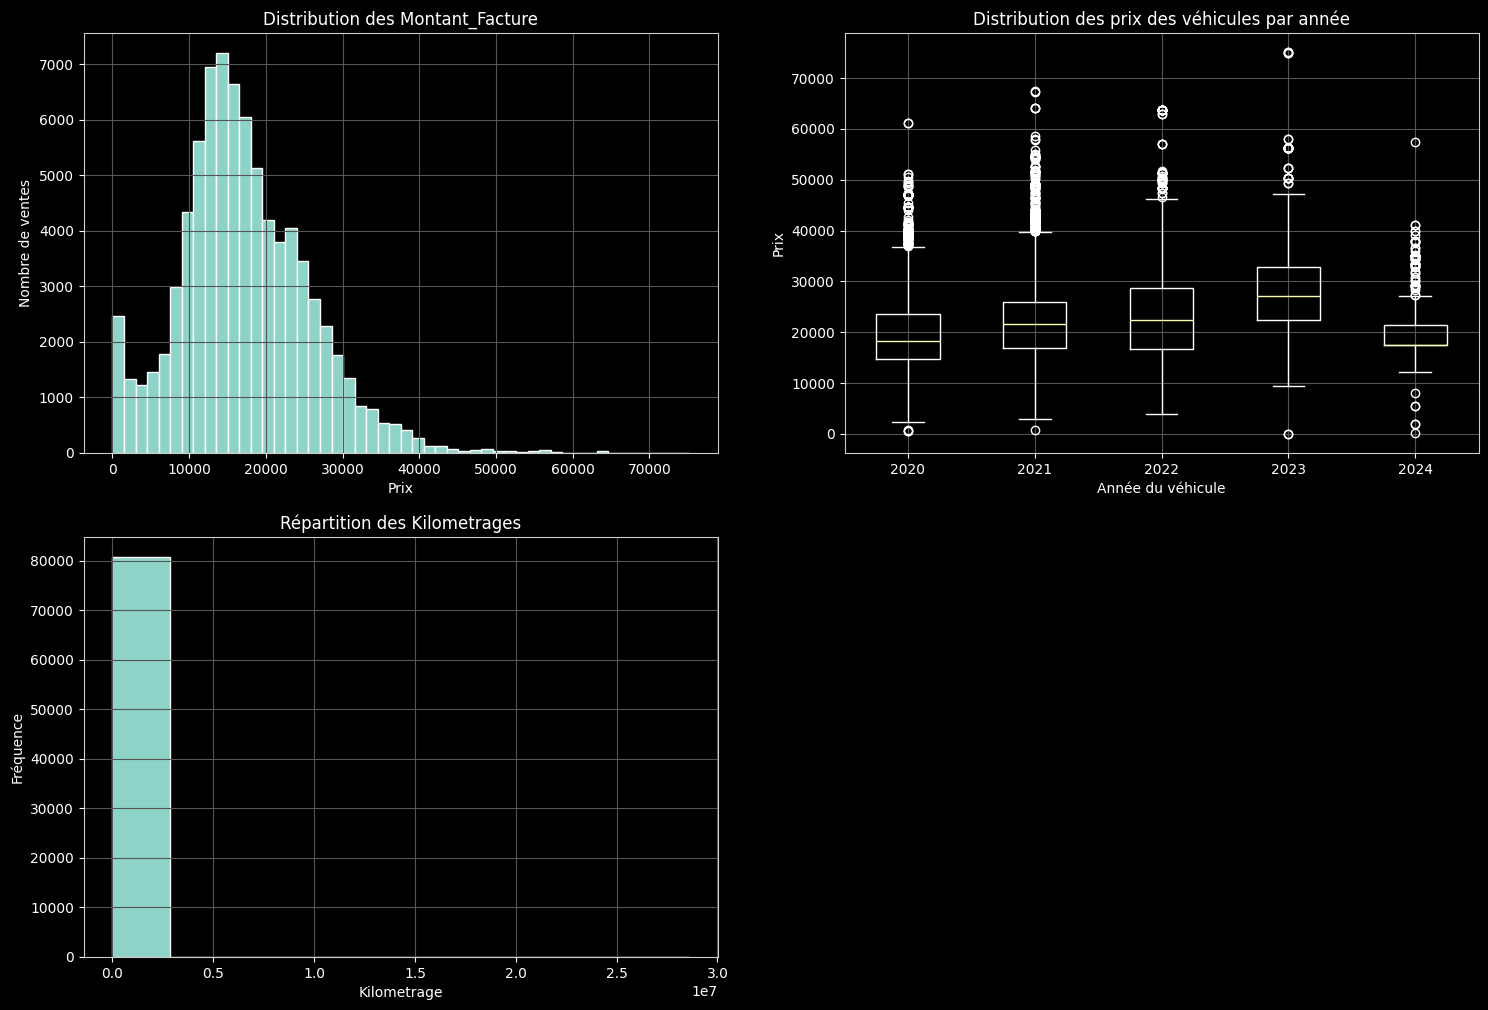

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

ax1.hist(df['Montant_Facture'], bins=50)
ax1.set_title('Distribution des Montant_Facture')
ax1.set_xlabel('Prix')
ax1.set_ylabel('Nombre de ventes')


years = sorted(df['Annee_Facture'].unique())
price_per_year = [df.loc[df['Annee_veh'] == annee, 'Montant_Facture'] for annee in years]

ax2.boxplot(price_per_year, labels=years)
ax2.set_title('Distribution des prix des véhicules par année')
ax2.set_xlabel('Année du véhicule')
ax2.set_ylabel('Prix')

ax3.hist(df['Kilometrage'])
ax3.set_title('Répartition des Kilometrages')
ax3.set_xlabel('Kilometrage')
ax3.set_ylabel('Fréquence')

ax4.set_axis_off()

## Nettoyage des données (IQR)
Le nettoyage s’appuie sur la méthode de l’Interquartile Range (IQR) afin de supprimer les valeurs extrêmes sur le prix (Montant_Facture) et le kilométrage (Kilometrage).

L’objectif est d’éliminer les observations sous-évaluées ou surévaluées qui pourraient biaiser le modèle, tout en conservant un volume de données suffisant pour l’apprentissage.

Des graphiques avant/après illustrent l’impact du filtrage sur les distributions.

In [56]:
# Cleaning
df_clean = df.copy()

# Filtrage sur Montant
IQR = df_clean['Montant_Facture'].quantile(0.75) - df_clean['Montant_Facture'].quantile(0.25)
df_clean = df_clean[(df_clean['Montant_Facture'] >= df_clean['Montant_Facture'].quantile(0.25) - 1.5 * IQR) & (df_clean['Montant_Facture'] <= df_clean['Montant_Facture'].quantile(0.75) + 1.5 * IQR)]
df_clean = df_clean[df_clean['Montant_Facture'] >= 1000]

# Filtrage sur Kilometrage
IQR = df_clean['Kilometrage'].quantile(0.75) - df_clean['Kilometrage'].quantile(0.25)
df_clean = df_clean[(df_clean['Kilometrage'] >= df_clean['Kilometrage'].quantile(0.25) - 1.5 * IQR) & (df_clean['Kilometrage'] <= df_clean['Kilometrage'].quantile(0.75) + 1.5 * IQR)]

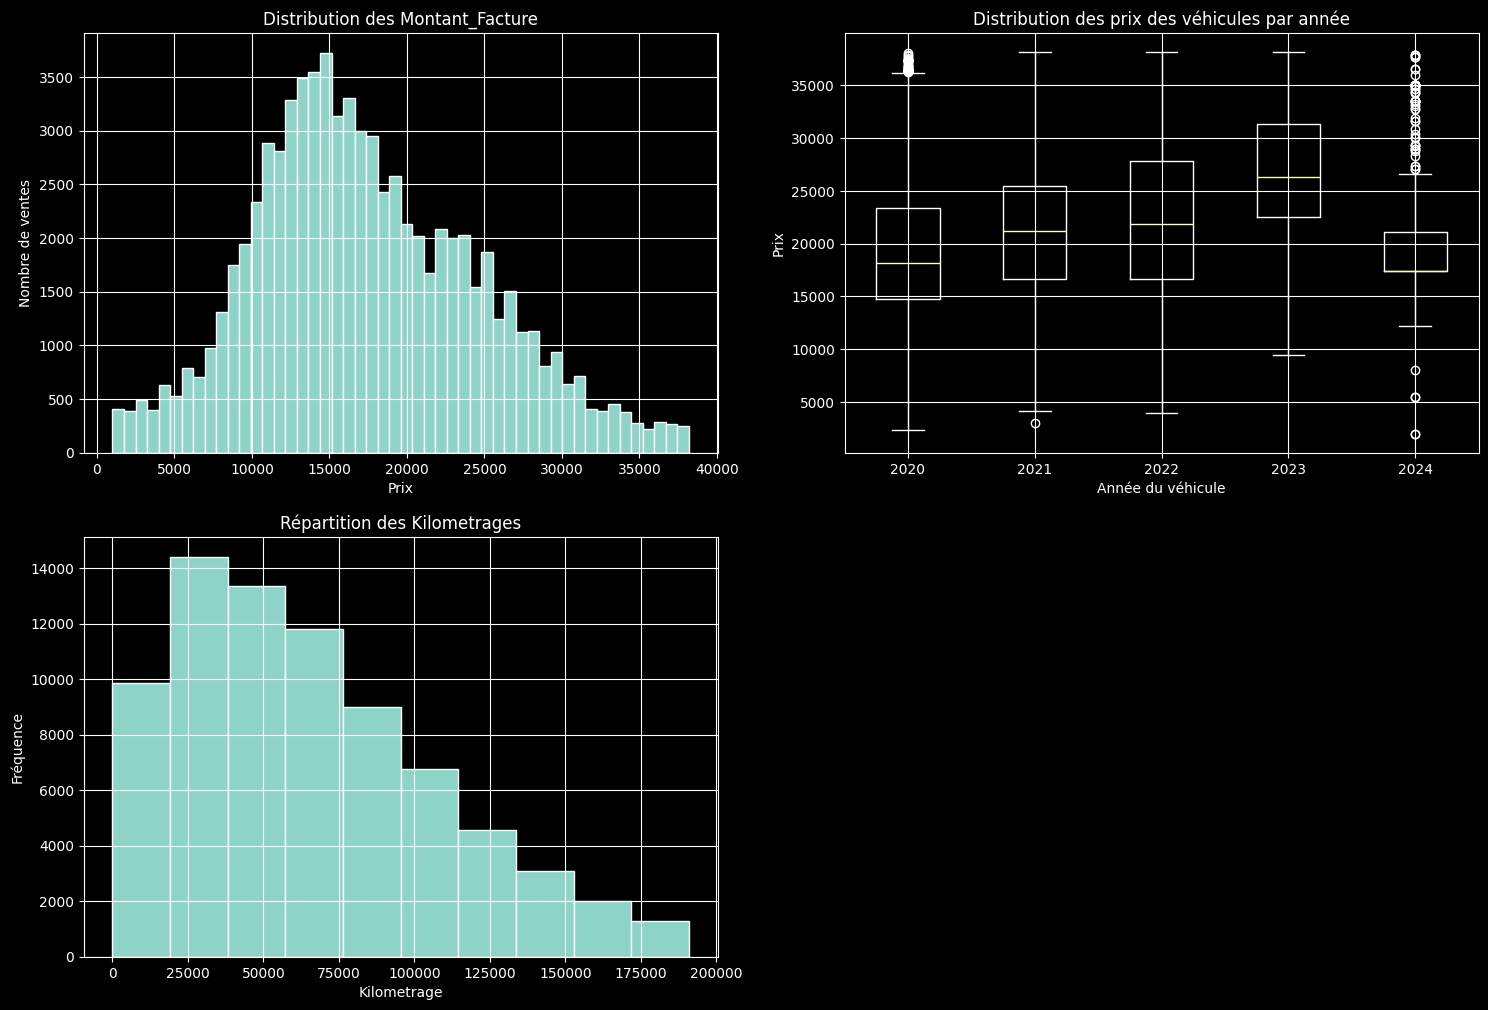

In [57]:
# Plot after clean
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

ax1.hist(df_clean['Montant_Facture'], bins=50)
ax1.set_title('Distribution des Montant_Facture')
ax1.set_xlabel('Prix')
ax1.set_ylabel('Nombre de ventes')


years = sorted(df_clean['Annee_Facture'].unique())
price_per_year = [df_clean.loc[df['Annee_veh'] == annee, 'Montant_Facture'] for annee in years]

ax2.boxplot(price_per_year, labels=years)
ax2.set_title('Distribution des prix des véhicules par année')
ax2.set_xlabel('Année du véhicule')
ax2.set_ylabel('Prix')

ax3.hist(df_clean['Kilometrage'])
ax3.set_title('Répartition des Kilometrages')
ax3.set_xlabel('Kilometrage')
ax3.set_ylabel('Fréquence')

ax4.set_axis_off()

## Feature Engineering
Nous enrichissons le jeu de données avec des variables dérivées visant à capturer la structure temporelle et l’usure des véhicules.

Cela inclut l’âge du véhicule, la durée de non-utilisation (not_used, pour des véhicules stocker ou exposer), différents ratios de kilométrage par an, ainsi que des transformations mathématiques (logarithmes, racines, puissances, inverses) sur l’âge, le kilométrage et not_used.

Ces nouvelles caractéristiques offrent au modèle une représentation plus flexible des relations non linéaires entre les variables explicatives et le prix.

In [58]:
# Feature Engineering

# Age
current_year = 2026
df_clean['age'] = current_year - df_clean['Annee_veh']
df_clean['not_used'] = np.clip(df_clean['Annee_Facture'] - df_clean['Annee_veh'], 0, float('inf'))

# Kilométrage
df_clean['km_per_year'] = df_clean['Kilometrage'] / df_clean['age'].clip(lower=1)
df_clean['log_km_per_year'] = np.log1p(df_clean['km_per_year'])
df_clean['sqrt_km_per_year'] = np.sqrt(df_clean['km_per_year'])
df_clean['square_km_per_year'] = np.square(df_clean['km_per_year'])
df_clean['cube_km_per_year'] = df_clean['km_per_year']**3
df_clean['inv_km_per_year'] = np.where(df_clean['km_per_year'] > 0, 1 / df_clean['km_per_year'], 0)


# Transformations
df_clean['log_km'] = np.log1p(df_clean['Kilometrage'])
df_clean['sqrt_km'] = np.sqrt(df_clean['Kilometrage'])
df_clean['square_km'] = np.square(df_clean['Kilometrage'])
df_clean['cube_km'] = df_clean['Kilometrage']**3
df_clean['inv_km'] = np.where(df_clean['Kilometrage'] > 0, 1 / df_clean['Kilometrage'], 0)
df_clean['log_inv_km'] = np.log1p(df_clean['inv_km'])

df_clean['log_age'] = np.log1p(df_clean['age'])
df_clean['sqrt_age'] = np.sqrt(df_clean['age'])
df_clean['square_age'] = np.square(df_clean['age'])
df_clean['cube_age'] = df_clean['age']**3
df_clean['inv_age'] = np.where(df_clean['age'] > 0, 1 / df_clean['age'], 0)

df_clean['log_not_used'] = np.log1p(df_clean['not_used'])
df_clean['sqrt_not_used'] = np.sqrt(df_clean['not_used'])
df_clean['square_not_used'] = np.square(df_clean['not_used'])
df_clean['cube_not_used'] = df_clean['not_used']**3
df_clean['inv_not_used'] = np.where(df_clean['not_used'] > 0, 1 / df_clean['not_used'], 0)
df_clean['log_inv_not_used'] = np.log1p(df_clean['inv_not_used'])

## Analyse en composantes principales (PCA)
Une série d’ACP est réalisée sur les variables numériques standardisées afin de comprendre la structure de variance du jeu de données.

Dans un premier temps, toutes les variables dérivées sont incluses, ce qui permet d’identifier les plus contributives aux premières composantes principales.

Dans un second temps, l’analyse est restreinte à des sous-ensembles de variables, jusqu’à retenir un petit noyau de variables numériques jugées les plus pertinentes.

Cette approche guide la sélection de features pour la phase de modélisation.

In [90]:
# ACP (PCA) : Variables numériques

# 1) Sélectionner variables numériques

numeric_cols = [
    # Colonnes originales
    'Annee_veh', 'Annee_Facture', 'Kilometrage',

    # Features Engineering Age
    'age', 'not_used',

    # Kilométrage ratios
    'km_per_year', 'log_km_per_year', 'sqrt_km_per_year',
    'square_km_per_year', 'cube_km_per_year', 'inv_km_per_year',

    # Transformations Kilometrage
    'log_km', 'sqrt_km', 'square_km', 'cube_km', 'inv_km', 'log_inv_km',

    # Transformations Age
    'log_age', 'sqrt_age', 'square_age', 'cube_age', 'inv_age',

    # Transformations not_used
    'log_not_used', 'sqrt_not_used', 'square_not_used',
    'cube_not_used', 'inv_not_used', 'log_inv_not_used'
]


X_numeric = df_clean[numeric_cols].copy()

# 2) Standardiser
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_numeric)

# 3) Appliquer PCA
pca = PCA()
X_pca = pca.fit_transform(X_num_scaled)

# 4) Variance expliquée
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

print(f"Variance expliquée par chaque composante:")
for i, var in enumerate(pca.explained_variance_ratio_[:5]):
    # Variables dominantes pour cette PC
    loadings_pc = np.abs(pca.components_[i])
    top_vars_idx = np.argsort(loadings_pc)[-3:][::-1]  # Top 3
    top_vars = [numeric_cols[idx] for idx in top_vars_idx]

    print(f"  PC{i+1}: {var*100:.2f}% — Variables: {', '.join(top_vars)}")

print(f"\nVariance cumulée (PC1-PC3): {cumsum_var[1]*100:.2f}%")

Variance expliquée par chaque composante:
  PC1: 43.71% — Variables: not_used, age, Annee_veh
  PC2: 22.48% — Variables: km_per_year, sqrt_km_per_year, square_km_per_year
  PC3: 12.03% — Variables: log_inv_km, inv_km, inv_km_per_year
  PC4: 7.16% — Variables: Annee_Facture, inv_not_used, log_inv_not_used
  PC5: 5.83% — Variables: cube_not_used, inv_not_used, log_inv_not_used

Variance cumulée (PC1-PC3): 66.19%


In [91]:
# ACP (PCA) : Variables numériques

# 1) Sélectionner variables numériques

numeric_cols = [
    'not_used', 'log_inv_km','km_per_year', 'Annee_Facture', 'cube_not_used'
]


X_numeric = df_clean[numeric_cols].copy()

# 2) Standardiser
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_numeric)

# 3) Appliquer PCA
pca = PCA()
X_pca = pca.fit_transform(X_num_scaled)

# 4) Variance expliquée
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

print(f"Variance expliquée par chaque composante:")
for i, var in enumerate(pca.explained_variance_ratio_[:5]):
    # Variables dominantes pour cette PC
    loadings_pc = np.abs(pca.components_[i])
    top_vars_idx = np.argsort(loadings_pc)[-3:][::-1]  # Top 3
    top_vars = [numeric_cols[idx] for idx in top_vars_idx]

    print(f"  PC{i+1}: {var*100:.2f}% — Variables: {', '.join(top_vars)}")

print(f"\nVariance cumulée (PC1-PC3): {cumsum_var[1]*100:.2f}%")

Variance expliquée par chaque composante:
  PC1: 36.46% — Variables: not_used, cube_not_used, Annee_Facture
  PC2: 25.30% — Variables: km_per_year, log_inv_km, cube_not_used
  PC3: 17.79% — Variables: Annee_Facture, log_inv_km, cube_not_used
  PC4: 14.86% — Variables: km_per_year, log_inv_km, Annee_Facture
  PC5: 5.60% — Variables: not_used, cube_not_used, Annee_Facture

Variance cumulée (PC1-PC3): 61.76%


In [92]:
# Plot PCA
plot_pca_biplot_adaptive(X_num_scaled, numeric_cols, n_components='auto')

(PCA(n_components=3),
 array([[-0.00385597,  0.34546541,  0.37399352],
        [ 1.98388246, -0.381236  ,  0.76748298],
        [-0.9592976 , -1.2653492 , -1.20548131],
        ...,
        [-1.10260044, -0.77815271, -1.20457436],
        [-1.12805806, -0.85023368, -1.20183946],
        [-1.12805806, -0.85023368, -1.20183946]], shape=(76189, 3)))

## Analyse des correspondances multiples (MCA)
Nous appliquons une MCA sur les variables qualitatives Type_Energie et Carburant afin d’explorer les associations entre les différentes modalités de carburant et de motorisation.

La forte granularité (nombre de modalités) limite la lisibilité globale, c'est donc pour cela que nous n'ajouterons pas les Marques et Modeles des voitures.

Cette analyse est principalement exploratoire et n’a pas d'impact direct dans le modèle final.

In [61]:
# MCA

# 1) Appliquer MCA
X_quali = df_clean[['Type_Energie','Carburant']]
mca = MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
).fit(X_quali)

# 2) Variance expliquée
var_ratio = mca.percentage_of_variance_
cumsum_var = mca.cumulative_percentage_of_variance_

print("Variance expliquée par chaque composante :")
for i, var in enumerate(var_ratio[:5]):
    # coordonnées des modalités (colonnes)
    column_coords = mca.column_coordinates(X_quali)
    loadings_dim = np.abs(column_coords.iloc[:, i])
    top_idx = np.argsort(loadings_dim)[-3:][::-1]
    top_cats = [column_coords.index[j] for j in top_idx]

    print(f"  Dim{i+1}: {var:.2f}% — Catégories: {', '.join(top_cats)}")

print(f"\nVariance cumulée (Dim1–Dim2): {cumsum_var[1]:.2f}%")

Variance expliquée par chaque composante :
  Dim1: 33.33% — Catégories: Type_Energie__Gaz, Type_Energie__Électrique, Carburant__Ne sais pas
  Dim2: 16.67% — Catégories: Type_Energie__Gaz, Type_Energie__Hybride, Type_Energie__Électrique

Variance cumulée (Dim1–Dim2): 50.00%


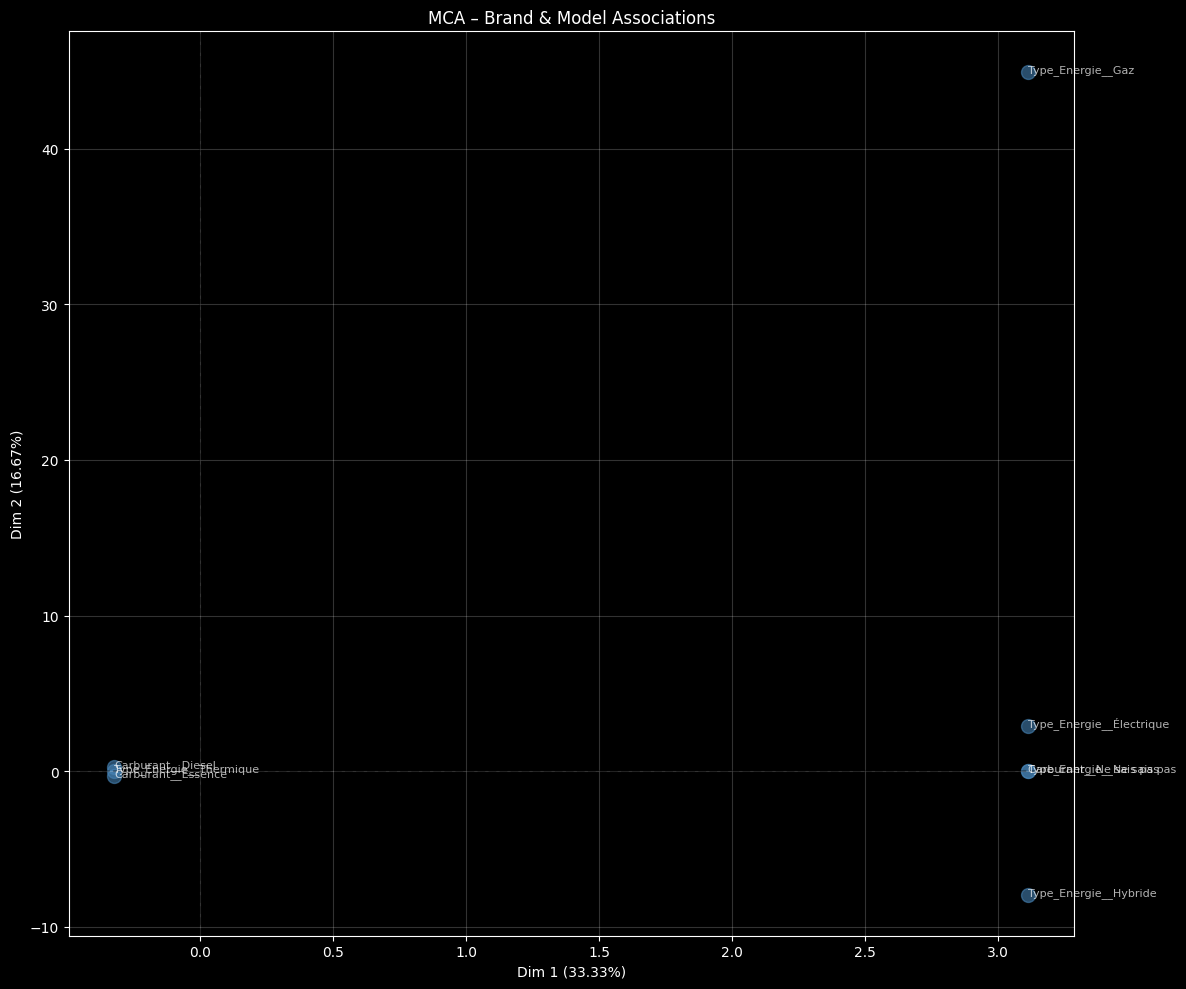

In [62]:
# Plot MCA
col_coords = mca.column_coordinates(X_quali)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot each category
ax.scatter(col_coords[0], col_coords[1], s=100, alpha=0.6, c='steelblue')

# Label them
for idx, label in enumerate(col_coords.index):
    ax.annotate(
        label,
        (col_coords.iloc[idx, 0], col_coords.iloc[idx, 1]),
        fontsize=8,
        alpha=0.7
    )

ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax.set_xlabel(f"Dim 1 ({mca.percentage_of_variance_[0]:.2f}%)")
ax.set_ylabel(f"Dim 2 ({mca.percentage_of_variance_[1]:.2f}%)")
ax.set_title("MCA – Brand & Model Associations")
ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

- ## Formatage, encodage et jeux d’entraînement/validation
    Les variables catégorielles (Marque_veh, Modele_veh, Type_Energie, Carburant) sont encodées via OneHotEncoder avec handle_unknown='ignore' pour gérer les catégories rares ou absentes.

    Les variables numériques sélectionnées (par exemple not_used, km_per_year, Annee_Facture) sont combinées avec ces encodages pour former la matrice de features 'X', tandis que la cible 'y' correspond au log du montant de facture.

    Un StratifiedKFold sur des binnings de 'y' est utilisé pour construire des jeux d’entraînement et de validation plus équilibrés, ce qui stabilise l’évaluation du modèle sur les différentes gammes de prix.

- ## Prétraitement avancé de la cible
    Sur chaque fold de validation croisée, la cible 'y' est transformée à l’aide d’un PowerTransformer (méthode Yeo–Johnson) afin de réduire l’asymétrie de sa distribution.

    Les valeurs transformées sont ensuite standardisées avec StandardScaler, donnant une cible centrée-réduite mieux adaptée à l’optimisation du MLP.

    Ce double prétraitement (PowerTransform + scaling) améliore la stabilité numérique et la qualité de la convergence du modèle.

In [84]:
# Formating and Ecoding
encoder_marque = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_modele = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_energie = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_carburant = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Encoding Marque_veh
marque_encoded = encoder_marque.fit_transform(df_clean[['Marque_veh']])

# Encoding Modele_veh
modele_encoded = encoder_modele.fit_transform(df_clean[['Modele_veh']])

# Encoding Energie
energie_encoded = encoder_energie.fit_transform(df_clean[['Type_Energie']])

# Encoding Carburant
carburant_encoded = encoder_carburant.fit_transform(df_clean[['Carburant']])

# Creating Train/Validation Sets using Stratified K-Fold Cross Validation
# X
X = np.hstack([df_clean[['not_used', 'log_inv_km', 'km_per_year', 'Annee_Facture', 'cube_not_used']].values, marque_encoded, modele_encoded, energie_encoded, carburant_encoded])

# y
y = np.log1p(df_clean['Montant_Facture'].values)

In [85]:
price_bins = pd.cut(y, bins = 128, labels = False)

# Use StratifiedKFold instead of KFold
skf = StratifiedKFold(n_splits=128, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X, price_bins)):
    X_train_raw, X_test_raw = X[train_index], X[test_index]
    y_train_raw, y_test_raw = y[train_index], y[test_index]

    # Fit scaler sur X train
    scaler_X_fold = StandardScaler()
    X_train_scaled = scaler_X_fold.fit_transform(X_train_raw)
    X_test_scaled = scaler_X_fold.transform(X_test_raw)  # Transform seulement

    # Fit power transformer sur Y train
    power_transformer_y_fold = sk.preprocessing.PowerTransformer(method='yeo-johnson')
    y_train_pt = power_transformer_y_fold.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
    y_test_pt = power_transformer_y_fold.transform(y_test_raw.reshape(-1, 1)).flatten() # Transform seulement

    # Fit scaler y sur Y train
    scaler_y_fold = StandardScaler()
    y_train_scaled = scaler_y_fold.fit_transform(y_train_pt.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y_fold.transform(y_test_pt.reshape(-1, 1)).flatten() # Transform seulement

- ## Entraînement du modèle MLPRegressor
    Nous entraînons un réseau de neurones de type MLPRegressor, avec une architecture profonde de taille (64, 64, 64) et une activation ReLU.

    Le modèle est optimisé avec l’algorithme Adam, un taux d’apprentissage adaptatif, une régularisation L2 (alpha) et un early stopping basé sur une fraction de validation interne.

    Les performances sont évaluées via la MAPE et l’analyse des résidus, ce qui permet de juger la qualité des prédictions sur l’échelle standardisée.

    L'architecture (64, 64, 64) n'est pas choisi au hasard, elle est le fruit de multiples tests dont les résultats en font la meilleur architecture pour ce problème.

    (Les résultats des tests sont en annexes de ce notebook)

In [86]:
# Model Training

model = MLPRegressor(
    hidden_layer_sizes=(64, 64, 64),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42,
    alpha=0.001,  # L2 regularization to avoid colinearity problems
    batch_size=32,
    early_stopping=True,
    validation_fraction=0.1
)

# Fit and store test predictions to avoid re-fitting later
model.fit(X_train_scaled, y_train_scaled)

y_pred_test = model.predict(X_test_scaled)
mape_score = np.median(np.abs((y_test_scaled - y_pred_test) / y_test_scaled)) * 100
test_residuals = y_test_scaled - y_pred_test

print(f"MAPE Score: {mape_score:.4f}")
print(f"Residual Std: {np.std(test_residuals):.4f}")
print("-" * 50)

# Model score

mape_score = mape_score
test_residuals = test_residuals
test_std = y_pred_test.std()

# Results
print(f"MAPE Score: {mape_score:.4f}")
print(f"Residual: {test_residuals.mean()}")
print(f"Std: {test_std}")

MAPE Score: 34.9156
Residual Std: 0.4003
--------------------------------------------------
MAPE Score: 34.9156
Residual: 0.0021014486506759607
Std: 0.9398475267355139


- ## Sauvegarde et chargement du meilleur modèle
    Une fois le modèle jugé satisfaisant, tous les composants nécessaires à la prédiction sont regroupés dans un dictionnaire : modèle final, scalers (X et y), PowerTransformer, et encodeurs catégoriels.

    Ce package est sérialisé dans un fichier vehicle_price_model.pkl via pickle, ce qui permet de réutiliser exactement le même pipeline de prétraitement et de prédiction en production.

    Une cellule dédiée montre également comment recharger ce package, extraire les objets et les utiliser pour des prédictions ultérieures.

In [87]:
# Save best_model

# Create a dictionary with all components
model_package = {
    "model": best_model,
    "scaler_X": scaler_X_fold,
    "scaler_y": scaler_y_fold,
    "power_y": power_transformer_y_fold,
    "encoder_marque": encoder_marque,
    "encoder_modele": encoder_modele,
    "encoder_energie": encoder_energie,
    "encoder_carburant": encoder_carburant
}

# Save the entire package
with open('vehicle_price_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Full model package saved!")

Full model package saved!


In [93]:
# Load best_model
with open('vehicle_price_model.pkl', 'rb') as f:
    model_package = pickle.load(f)

# Extract components
best_model = model_package['model']
scaler_X = model_package['scaler_X']
scaler_y = model_package['scaler_y']
power_transformer_y_fold = model_package['power_y']
encoder_marque = model_package['encoder_marque']
encoder_modele = model_package['encoder_modele']
encoder_energie = model_package['encoder_energie']
encoder_carburant = model_package['encoder_carburant']

- ## Évaluation finale du modèle et diagnostics
    Dans cette dernière partie, le modèle sauvegardé est appliqué à l’ensemble de df_clean pour produire des prédictions de prix en euros.

    Les étapes d’inférence reproduisent strictement la chaîne inverse (scaling inverse, inverse du PowerTransformer, expm1 sur la cible) afin de revenir à l’échelle d’origine.

    Nous calculons les résidus sur les observations valides, ainsi que des statistiques globales (moyenne, écart-type) et des diagnostics visuels :

    - prédictions vs valeurs réelles,

    - distribution des résidus,

    - résidus en fonction du prix prédit,

    - séries indexées comparant prix réel et prédit.

    Ces graphiques permettent de vérifier visuellement la qualité du modèle, d’identifier d’éventuels biais systématiques et de repérer des zones de prix où les erreurs sont plus importantes.

In [94]:
# 1. Encoding (fit_transform sur df_clean complet)
encoder_marque = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_modele = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_energie = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_carburant = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

marque_encoded = encoder_marque.fit_transform(df_clean[['Marque_veh']])
modele_encoded = encoder_modele.fit_transform(df_clean[['Modele_veh']])
energie_encoded = encoder_energie.fit_transform(df_clean[['Type_Energie']])
carburant_encoded = encoder_carburant.fit_transform(df_clean[['Carburant']])

# 2. Construction de X
numeric_features = df_clean[['not_used', 'log_inv_km', 'km_per_year', 'Annee_Facture', 'cube_not_used']].values
X = np.hstack([numeric_features, marque_encoded, modele_encoded, energie_encoded, carburant_encoded])

# 3. y transformé (pour référence, mais pas utilisé pour prédiction)
y = np.log1p(df_clean['Montant_Facture'].values)

# 4. CHARGER LES OBJETS DU MODÈLE SAUVEGARDÉS (adapte le chemin)
with open('vehicle_price_model.pkl', 'rb') as f:  # Remplace par ton fichier réel
    model_package = pickle.load(f)

scaler_X_fold = model_package['scaler_X']
scaler_y_fold = model_package['scaler_y']
power_transformer_y_fold = model_package['power_y']
best_model = model_package['model']

data_to_score = df_clean.copy()
n = len(data_to_score)

# 5. Aligner features pour scaler (gérer mismatch dimensions)
scaler_expected_n_features = getattr(scaler_X_fold, 'n_features_in_', X.shape[1])
if X.shape[1] > scaler_expected_n_features:
    X_all_for_scaler = X[:, :scaler_expected_n_features]
elif X.shape[1] < scaler_expected_n_features:
    pad_width = scaler_expected_n_features - X.shape[1]
    X_all_for_scaler = np.hstack([X, np.zeros((n, pad_width))])
else:
    X_all_for_scaler = X

X_all_scaled = scaler_X_fold.transform(X_all_for_scaler)

# 6. Aligner pour le modèle
model_expected_n_features = getattr(best_model, 'n_features_in_', X_all_scaled.shape[1])
if X_all_scaled.shape[1] > model_expected_n_features:
    X_all_scaled = X_all_scaled[:, :model_expected_n_features]
elif X_all_scaled.shape[1] < model_expected_n_features:
    pad_width = model_expected_n_features - X_all_scaled.shape[1]
    X_all_scaled = np.hstack([X_all_scaled, np.zeros((n, pad_width))])

# 7. Prédictions row-by-row
y_pred_scaled = np.empty(n, dtype=float)
for i in range(n):
    y_pred_scaled[i] = best_model.predict(X_all_scaled[i:i+1])[0]

# 8. Inverse transforms (avec reshape 2D pour les transformers)
y_pred_scaled_2d = y_pred_scaled.reshape(-1, 1)

y_pred_unscaled = scaler_y_fold.inverse_transform(y_pred_scaled_2d).ravel()
y_pred_unscaled = np.where(np.isfinite(y_pred_unscaled), y_pred_unscaled, np.nan)

y_pred_pt = power_transformer_y_fold.inverse_transform(y_pred_unscaled.reshape(-1, 1)).ravel()
y_pred_pt = np.where(np.isfinite(y_pred_pt), y_pred_pt, np.nan)

y_pred_eur = np.expm1(y_pred_pt)
y_pred_eur = np.where(np.isfinite(y_pred_eur), y_pred_eur, np.nan)

# 9. Résidus sur valeurs finies
y_true_eur = df_clean['Montant_Facture'].to_numpy(dtype=float)
y_true_eur = np.where(np.isfinite(y_true_eur), y_true_eur, np.nan)

residuals_eur = y_true_eur - y_pred_eur

valid_mask = np.isfinite(y_true_eur) & np.isfinite(y_pred_eur) & np.isfinite(residuals_eur)
residuals_eur_valid = residuals_eur[valid_mask]

res_mean = np.nanmean(residuals_eur_valid) if len(residuals_eur_valid) > 0 else np.nan
res_std = np.nanstd(residuals_eur_valid) if len(residuals_eur_valid) > 0 else np.nan

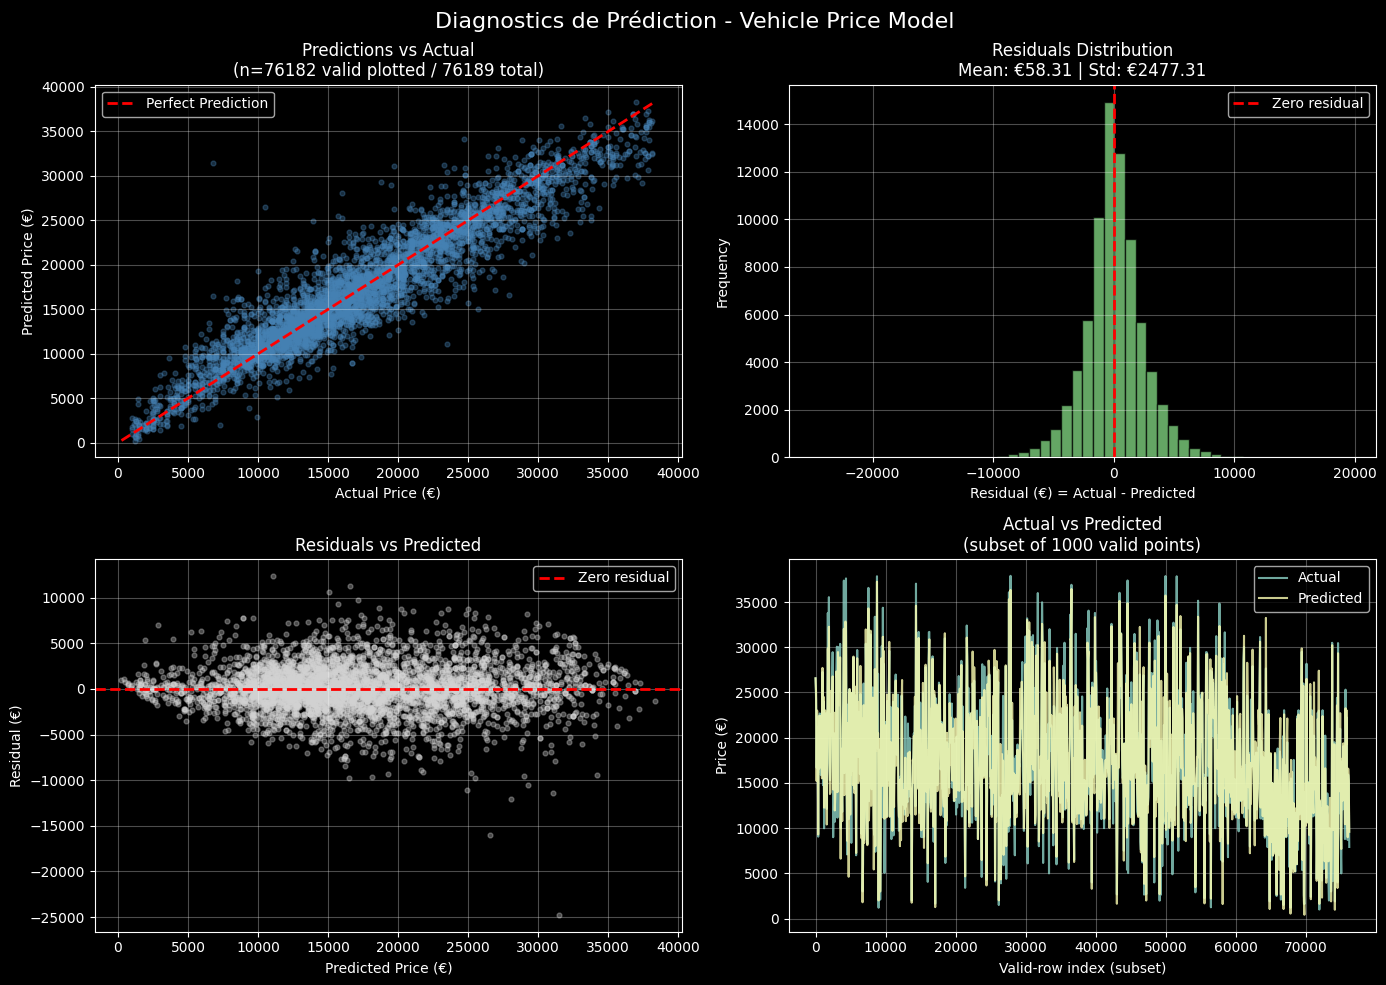

In [95]:
# 8) Plots (subplots)
plot_n = int(valid_mask.sum())
rng = np.random.default_rng(42)
plot_idx = rng.choice(plot_n, size=min(5000, plot_n), replace=False) if plot_n > 0 else np.array([], dtype=int)  # Limite à 5000 pts pour perf

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Predictions vs Actual
ax1 = axes[0, 0]
if plot_n > 0:
    ax1.scatter(y_true_eur[valid_mask][plot_idx], y_pred_eur[valid_mask][plot_idx],
                alpha=0.35, s=12, color='steelblue')
    min_val = min(y_true_eur[valid_mask][plot_idx].min(), y_pred_eur[valid_mask][plot_idx].min())
    max_val = max(y_true_eur[valid_mask][plot_idx].max(), y_pred_eur[valid_mask][plot_idx].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price (€)')
ax1.set_ylabel('Predicted Price (€)')
ax1.set_title(f'Predictions vs Actual\n(n={plot_n} valid plotted / {n} total)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals distribution
ax2 = axes[0, 1]
if len(residuals_eur_valid) > 0:
    ax2.hist(residuals_eur_valid, bins=min(50, len(residuals_eur_valid)//10), alpha=0.7, edgecolor='black', color='lightgreen')
ax2.axvline(0, color='red', linestyle='--', lw=2, label='Zero residual')
ax2.set_xlabel('Residual (€) = Actual - Predicted')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Residuals Distribution\nMean: €{res_mean:.2f} | Std: €{res_std:.2f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals vs Predicted
ax3 = axes[1, 0]
if plot_n > 0:
    ax3.scatter(y_pred_eur[valid_mask][plot_idx], residuals_eur[valid_mask][plot_idx],
                alpha=0.35, s=12, color='lightgrey')
ax3.axhline(0, color='red', linestyle='--', lw=2, label='Zero residual')
ax3.set_xlabel('Predicted Price (€)')
ax3.set_ylabel('Residual (€)')
ax3.set_title('Residuals vs Predicted')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Actual vs Predicted over index (subset pour lisibilité)
ax4 = axes[1, 1]
line_n = min(1000, plot_n)  # Limite à 1000 lignes pour éviter surcharge
if plot_n > 0 and line_n > 0:
    line_idx = np.linspace(0, plot_n - 1, num=line_n, dtype=int)
    ax4.plot(line_idx, y_true_eur[valid_mask][line_idx], label='Actual', lw=1.5, alpha=0.8)
    ax4.plot(line_idx, y_pred_eur[valid_mask][line_idx], label='Predicted', lw=1.5, alpha=0.8)
ax4.set_xlabel('Valid-row index (subset)')
ax4.set_ylabel('Price (€)')
ax4.set_title(f'Actual vs Predicted\n(subset of {line_n} valid points)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Diagnostics de Prédiction - Vehicle Price Model', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

- ## Annexe

    - Résultats des tests d'architecture

### Première recherche global

Architecture: (32,)
MAPE Score: 43.8565
Residual Std: 0.4879
--------------------------------------------------
Architecture: (64,)
MAPE Score: 43.1358
Residual Std: 0.4994
--------------------------------------------------
Architecture: (32, 16)
MAPE Score: 41.9217
Residual Std: 0.4728
--------------------------------------------------
Architecture: (64, 32)
MAPE Score: 38.9122
Residual Std: 0.4900
--------------------------------------------------
Architecture: (64, 64)
MAPE Score: 41.0054
Residual Std: 0.4658
--------------------------------------------------
Architecture: (128,)
MAPE Score: 43.9086
Residual Std: 0.5009
--------------------------------------------------
Architecture: (128, 64)
MAPE Score: 40.3873
Residual Std: 0.4651
--------------------------------------------------
Architecture: (128, 64, 32)
MAPE Score: 38.6055
Residual Std: 0.4622
--------------------------------------------------
Architecture: (64, 128, 64)
MAPE Score: 41.2843
Residual Std: 0.4862
--------------------------------------------------
Architecture: (128, 128)
MAPE Score: 37.8667
Residual Std: 0.4606
--------------------------------------------------
Architecture: (128, 128, 64)
MAPE Score: 39.8924
Residual Std: 0.4657
--------------------------------------------------
Architecture: (128, 64, 64)
MAPE Score: 37.0126
Residual Std: 0.4661
--------------------------------------------------
Architecture: (256, 128, 64)
MAPE Score: 38.5490
Residual Std: 0.4679
--------------------------------------------------
Architecture: (256, 128, 32)
MAPE Score: 39.4908
Residual Std: 0.4746
--------------------------------------------------
Architecture: (128, 128, 128)
MAPE Score: 37.4104
Residual Std: 0.4591
--------------------------------------------------
Architecture: (256, 128)
MAPE Score: 37.9024
Residual Std: 0.4639
--------------------------------------------------
Architecture: (256, 256)
MAPE Score: 39.9509
Residual Std: 0.4694
--------------------------------------------------
Architecture: (256, 256, 128)
MAPE Score: 39.6018
Residual Std: 0.4734
--------------------------------------------------
Architecture: (512, 256, 128)
MAPE Score: 40.7398
Residual Std: 0.4673
--------------------------------------------------
Architecture: (512, 256)
MAPE Score: 39.0157
Residual Std: 0.4652
--------------------------------------------------
Architecture: (512, 512, 256)
MAPE Score: 41.5683
Residual Std: 0.4586
--------------------------------------------------
Architecture: (256, 128, 128)
MAPE Score: 37.8466
Residual Std: 0.4677
--------------------------------------------------
Architecture: (128, 256, 128)
MAPE Score: 40.0702
Residual Std: 0.4701
--------------------------------------------------
Architecture: (64, 64, 64)
MAPE Score: 36.5449
Residual Std: 0.4636
--------------------------------------------------
======================================================================
Best Architecture: (64, 64, 64)
Best MAPE Score: 36.5449
Best Residual: 0.013936031612112399
======================================================================
(Ran during 8 hours and 11 minutes)

### Recherche affinée à partir du meilleur modèle en recherche global

Architecture: (48, 48, 48)
MAPE Score: 39.7275
Residual Std: 0.4772
--------------------------------------------------
Architecture: (64, 64, 64)
MAPE Score: 36.5449
Residual Std: 0.4636
--------------------------------------------------
Architecture: (80, 80, 80)
MAPE Score: 39.8610
Residual Std: 0.4617
--------------------------------------------------
Architecture: (96, 96, 96)
MAPE Score: 39.3483
Residual Std: 0.4553
--------------------------------------------------
Architecture: (64, 96, 64)
MAPE Score: 40.9223
Residual Std: 0.4672
--------------------------------------------------
Architecture: (64, 128, 64)
MAPE Score: 41.2843
Residual Std: 0.4862
--------------------------------------------------
Architecture: (96, 64, 96)
MAPE Score: 40.3104
Residual Std: 0.4749
--------------------------------------------------
Architecture: (64, 64, 64, 64)
MAPE Score: 37.8498
Residual Std: 0.4615
--------------------------------------------------
Architecture: (80, 80, 64, 64)
MAPE Score: 40.4586
Residual Std: 0.4671
--------------------------------------------------
Architecture: (96, 64, 64, 32)
MAPE Score: 38.9901
Residual Std: 0.4715
--------------------------------------------------
Architecture: (64, 64)
MAPE Score: 41.0054
Residual Std: 0.4658
--------------------------------------------------
Architecture: (96, 64)
MAPE Score: 38.0218
Residual Std: 0.4712
--------------------------------------------------
Architecture: (64, 96)
MAPE Score: 41.4508
Residual Std: 0.4666
--------------------------------------------------
Architecture: (48, 48, 48, 48)
MAPE Score: 37.2129
Residual Std: 0.4447
--------------------------------------------------
======================================================================
Best Architecture: (64, 64, 64)
Best MAPE Score: 36.5449
Best Residual: 0.013936031612112399
======================================================================
(Ran during 1 hours and 58 minutes)